In [40]:
import ticktack
import pandas
from jax.numpy import arange, sin, pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt

The basic question is what is the probability of detecting consecutive events based on the distribution of the data. The first step then will be to determine the distribution of the data. This will be done be resampling the points after the event has been removed.

In [33]:
def production(t):
    """
    Generates a simple sinusoidal production function
    """
    return 1.88 + 0.18 * 1.88 * sin(2 * pi / 11 * t + 1.25)

In [36]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()
burn_in, steady_state = cbm.run(arange(-360.0, 760.0), 12, 
    production=production, steady_state_production=1.88)

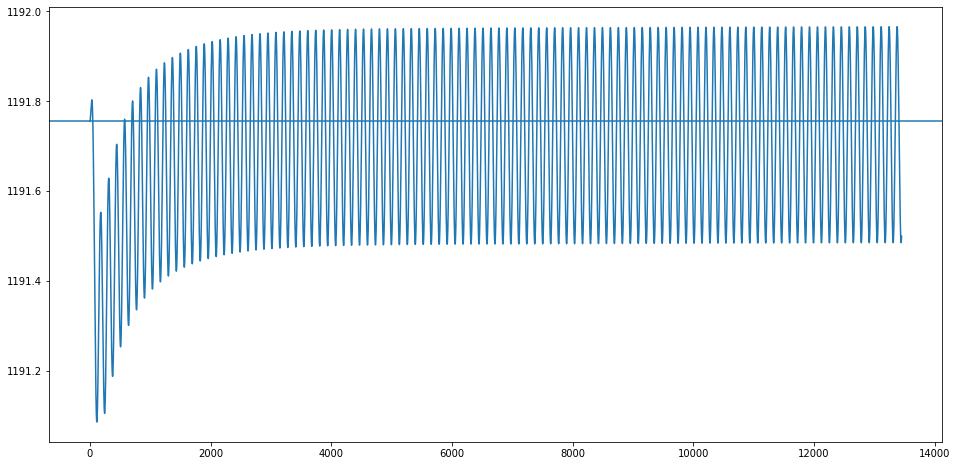

In [49]:
plt.figure("Burn Period")
plt.plot(burn_in[:, 2])
plt.axhline(steady_state[2])

In [28]:
annual_samples = 48                     # 4 samples per month
sample_times = arange(760.0, 774.0)  # Times at which to collect samples



So the data contains underlying trends that I want to remove so that I can get a better picture of the signal to noise ratio. I might start of by fitting the ideal event. I can do this using the infrastructure that Q has put in place.

In [ ]:
miyake = pandas.read_csv("Miyake12.csv", sep=" ")
miyake = miyake[miyake.d14c < -17.5]
miyake.plot(x="year", y="d14c")